Data exploration

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
from kaggle import api
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [4]:
!kaggle datasets download -d ayuraj/asl-dataset

Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
 88% 50.0M/56.9M [00:02<00:00, 19.6MB/s]
100% 56.9M/56.9M [00:02<00:00, 23.1MB/s]


In [5]:
import zipfile
z=zipfile.ZipFile('/content/asl-dataset.zip','r')
z.extractall('/content')
z.close()

Remove same folder within the folder

In [6]:
import shutil

# Directory to be deleted
directory_to_delete = '/content/asl_dataset/asl_dataset'

# Remove the directory and all its contents
shutil.rmtree(directory_to_delete)

Check the size of images

In [7]:
import os
from PIL import Image

# Path to the folder containing the images
folder_path = '/content/asl_dataset'

# Iterate through each class (0 to 9 and a to z)
for class_folder in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_folder)

    # Check if it is a directory
    if os.path.isdir(class_path):
        print(f"Class: {class_folder}")

        # Iterate through each image in the class folder
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Open the image using PIL
            with Image.open(image_path) as img:
                width, height = img.size
                print(f"Image: {image_name}, Size: {width}x{height}")

        print("-" * 30)

Class: d
Image: hand2_d_right_seg_4_cropped.jpeg, Size: 400x400
Image: hand1_d_dif_seg_3_cropped.jpeg, Size: 400x400
Image: hand1_d_bot_seg_3_cropped.jpeg, Size: 400x400
Image: hand1_d_bot_seg_5_cropped.jpeg, Size: 400x400
Image: hand5_d_dif_seg_4_cropped.jpeg, Size: 400x400
Image: hand4_d_bot_seg_5_cropped.jpeg, Size: 400x400
Image: hand5_d_bot_seg_5_cropped.jpeg, Size: 400x400
Image: hand2_d_top_seg_3_cropped.jpeg, Size: 400x400
Image: hand3_d_dif_seg_5_cropped.jpeg, Size: 400x400
Image: hand1_d_dif_seg_2_cropped.jpeg, Size: 400x400
Image: hand5_d_bot_seg_4_cropped.jpeg, Size: 400x400
Image: hand1_d_top_seg_4_cropped.jpeg, Size: 400x400
Image: hand5_d_dif_seg_5_cropped.jpeg, Size: 400x400
Image: hand1_d_dif_seg_1_cropped.jpeg, Size: 400x400
Image: hand5_d_dif_seg_3_cropped.jpeg, Size: 400x400
Image: hand5_d_bot_seg_1_cropped.jpeg, Size: 400x400
Image: hand5_d_dif_seg_2_cropped.jpeg, Size: 400x400
Image: hand1_d_dif_seg_4_cropped.jpeg, Size: 400x400
Image: hand1_d_top_seg_5_cropped.jp

Data Augmentation and preprocessing (All image sizes are 400x400) so it will be kept as it is.

In [8]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


The images are not normalized as the model was not able to capture the patterns

In [9]:
# # Data augmentation for the entire dataset
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),

])

# Define the transformation
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),

])

# Without augmentation

# train_transforms = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),  # Convert image to grayscale
#     transforms.ToTensor()
#     # transforms.Normalize(mean=[0.485], std=[0.229])  # Update normalization mean and std for grayscale
# ])

# # Define the transformation for testing
# test_transforms = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),  # Convert image to grayscale
#     transforms.ToTensor()
#     # transforms.Normalize(mean=[0.485], std=[0.229])  # Update normalization mean and std for grayscale
# ])

In [10]:
dataset_path = '/content/asl_dataset'

# Load the dataset with ImageFolder, which automatically assigns labels based on folder names
full_dataset = datasets.ImageFolder(root=dataset_path, transform=augmentation_transforms)
# full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)


Data split

In [11]:
# Calculate the lengths for training (80%) and testing (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Apply the test transformations to the test dataset (no augmentation, just normalization)
test_dataset.dataset.transform = test_transforms


In [12]:
# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Check image

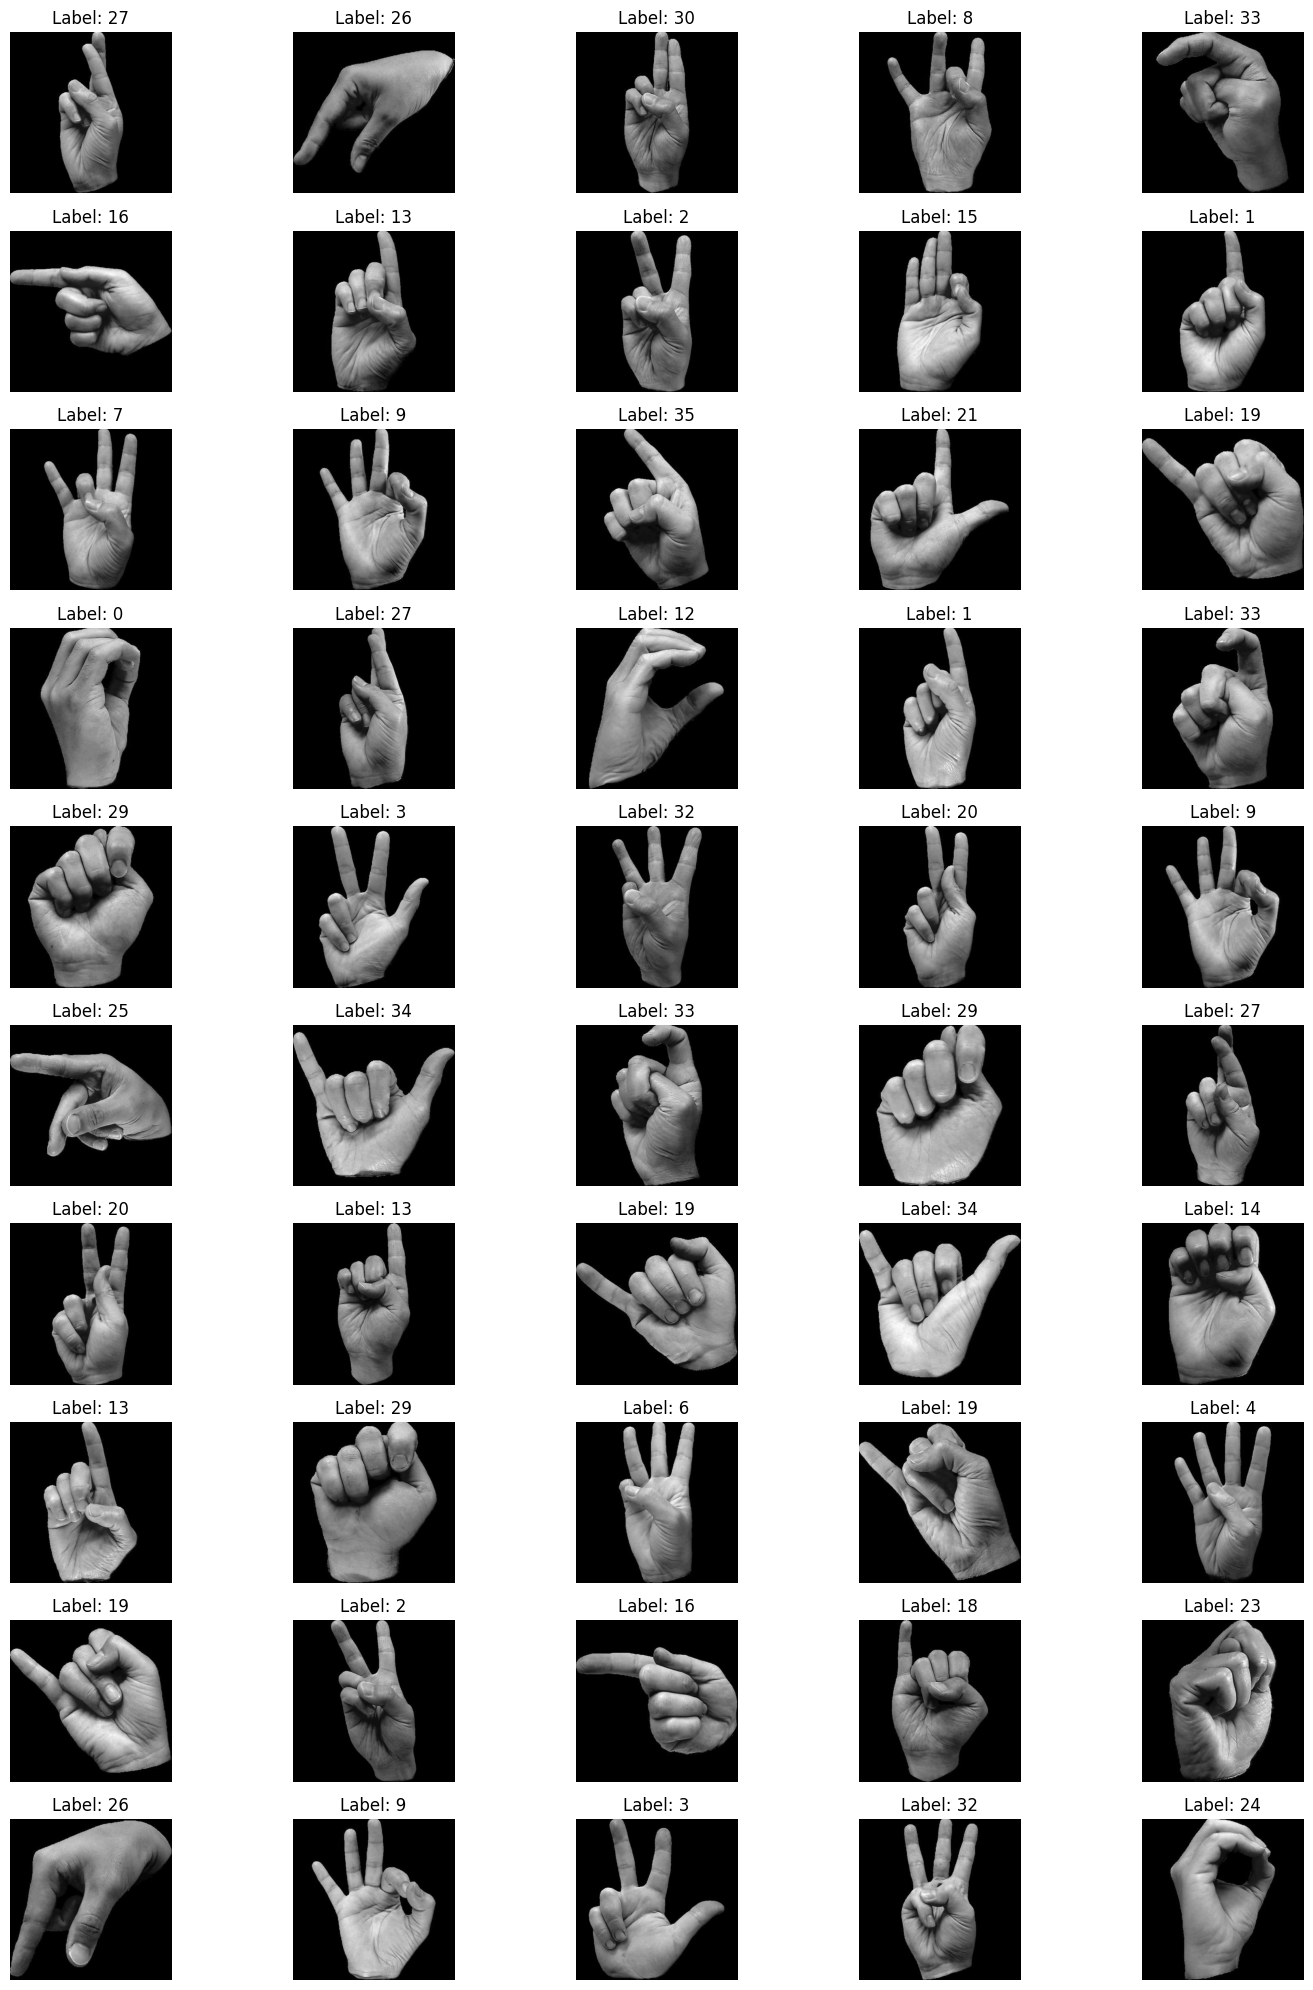

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

# Function to convert a tensor to an image
def tensor_to_image(tensor):
    # Check if the tensor is already in grayscale format
    if tensor.ndim == 4:  # Batch dimension exists
        tensor = tensor.squeeze(0)  # Remove batch dimension
    if tensor.ndim == 3:  # Grayscale image with channels
        tensor = tensor.squeeze(0)  # Remove single channel dimension

    tensor = tensor.cpu().numpy()  # Move to CPU and convert to numpy array

    if tensor.ndim == 2:  # No need to transpose for grayscale
        return tensor
    elif tensor.ndim == 3:
        tensor = np.transpose(tensor, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())  # Normalize to [0, 1]
        return tensor
    else:
        raise ValueError("Unexpected tensor dimensions")

# Collect 50 images and labels
images_list = []
labels_list = []
for images, labels in train_loader:
    images_list.append(images[0])
    labels_list.append(labels[0])
    if len(images_list) == 50:
        break

# Convert to tensors
images_tensor = torch.stack(images_list)
labels_tensor = torch.stack(labels_list)

# Create a grid of images
def plot_images_grid(images, labels, num_rows=10, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        display_image = tensor_to_image(img)
        ax.imshow(display_image, cmap='gray')  # Use cmap='gray' for grayscale images
        ax.set_title(f'Label: {label.item()}')  # Display label
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot the images in a 10x5 grid
plot_images_grid(images_tensor, labels_tensor)

Print image tensor, toTensor() is normalizing explicitly, so it is not need to normalize again.

In [14]:
import torch

# Function to print image tensor values
def print_image_tensor_values(loader, num_images=1):
    for i, (images, labels) in enumerate(loader):
        if i >= num_images:
            break

        # Get the first image in the batch
        image = images[0]
        label = labels[0]

        # Print tensor values
        print(f"Label: {label.item()}")
        print("Image Tensor Values:")
        print(image.unique())

        # Print the shape of the tensor
        print("Tensor Shape:", image.shape)

# Print tensor values for the first image in the DataLoader
print_image_tensor_values(train_loader, num_images=1)

Label: 8
Image Tensor Values:
tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3804, 0.3843,
        0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118, 0.4157, 0.4196,
        0.

In [15]:
categories = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "a", 11: "b", 12: "c", 13: "d", 14: "e", 15: "f", 16: "g", 17: "h", 18: "i",
    19: "j", 20: "k", 21: "l", 22: "m", 23: "n", 24: "o", 25: "p", 26: "q", 27: "r",
    28: "s", 29: "t", 30: "u", 31: "v", 32: "w", 33: "x", 34: "y", 35: "z"
}


Model creation

In [16]:
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [23]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 50 * 50, 512)  # Adjust based on output size after conv layers
        self.fc2 = nn.Linear(512, 36)  # Output layer for 36 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 50 * 50)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNModel().cuda()


In [24]:
print(model)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=36, bias=True)
)


In [25]:
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        images, labels = images.cuda(), labels.cuda()  # Move to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Testing Epoch {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.cuda(), labels.cuda()  # Move to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # Early stopping if the accuracy reaches 98%
    # if test_acc >= 98:
    #     print("Achieved 98% accuracy, stopping training early.")
    #     break

torch.save(model.state_dict(), 'cnn_model.pth')
print("Model saved as cnn_model.pth")

Testing Epoch 1/15: 100%|██████████| 16/16 [00:01<00:00,  9.07batch/s]


Epoch [1/15], Train Loss: 1.8637, Train Acc: 52.09%, Test Loss: 0.6789, Test Acc: 79.13%


Testing Epoch 2/15: 100%|██████████| 16/16 [00:01<00:00,  8.93batch/s]


Epoch [2/15], Train Loss: 0.3902, Train Acc: 87.97%, Test Loss: 0.2518, Test Acc: 91.25%


Testing Epoch 3/15: 100%|██████████| 16/16 [00:01<00:00,  9.06batch/s]


Epoch [3/15], Train Loss: 0.1347, Train Acc: 96.12%, Test Loss: 0.1994, Test Acc: 93.24%


Testing Epoch 4/15: 100%|██████████| 16/16 [00:01<00:00,  9.00batch/s]


Epoch [4/15], Train Loss: 0.0549, Train Acc: 98.31%, Test Loss: 0.1375, Test Acc: 96.22%


Testing Epoch 5/15: 100%|██████████| 16/16 [00:01<00:00,  9.04batch/s]


Epoch [5/15], Train Loss: 0.0403, Train Acc: 98.96%, Test Loss: 0.1619, Test Acc: 95.23%


Testing Epoch 6/15: 100%|██████████| 16/16 [00:01<00:00,  9.09batch/s]


Epoch [6/15], Train Loss: 0.0322, Train Acc: 98.96%, Test Loss: 0.1371, Test Acc: 95.63%


Testing Epoch 7/15: 100%|██████████| 16/16 [00:01<00:00,  9.14batch/s]


Epoch [7/15], Train Loss: 0.0113, Train Acc: 99.75%, Test Loss: 0.1312, Test Acc: 97.22%


Testing Epoch 8/15: 100%|██████████| 16/16 [00:01<00:00,  8.99batch/s]


Epoch [8/15], Train Loss: 0.0088, Train Acc: 99.75%, Test Loss: 0.1146, Test Acc: 96.42%


Testing Epoch 9/15: 100%|██████████| 16/16 [00:01<00:00,  9.11batch/s]


Epoch [9/15], Train Loss: 0.0308, Train Acc: 99.16%, Test Loss: 0.4925, Test Acc: 93.04%


Testing Epoch 10/15: 100%|██████████| 16/16 [00:01<00:00,  9.14batch/s]


Epoch [10/15], Train Loss: 0.0693, Train Acc: 98.86%, Test Loss: 0.4618, Test Acc: 89.66%


Testing Epoch 11/15: 100%|██████████| 16/16 [00:01<00:00,  8.92batch/s]


Epoch [11/15], Train Loss: 0.0567, Train Acc: 98.66%, Test Loss: 0.2056, Test Acc: 94.63%


Testing Epoch 12/15: 100%|██████████| 16/16 [00:01<00:00,  8.85batch/s]


Epoch [12/15], Train Loss: 0.0308, Train Acc: 99.50%, Test Loss: 0.2234, Test Acc: 94.43%


Testing Epoch 13/15: 100%|██████████| 16/16 [00:01<00:00,  8.99batch/s]


Epoch [13/15], Train Loss: 0.0120, Train Acc: 99.60%, Test Loss: 0.1820, Test Acc: 96.42%


Testing Epoch 14/15: 100%|██████████| 16/16 [00:01<00:00,  8.94batch/s]


Epoch [14/15], Train Loss: 0.0011, Train Acc: 99.95%, Test Loss: 0.1749, Test Acc: 96.02%


Testing Epoch 15/15: 100%|██████████| 16/16 [00:01<00:00,  9.06batch/s]


Epoch [15/15], Train Loss: 0.0001, Train Acc: 100.00%, Test Loss: 0.1709, Test Acc: 96.02%
Model saved as cnn_model.pth


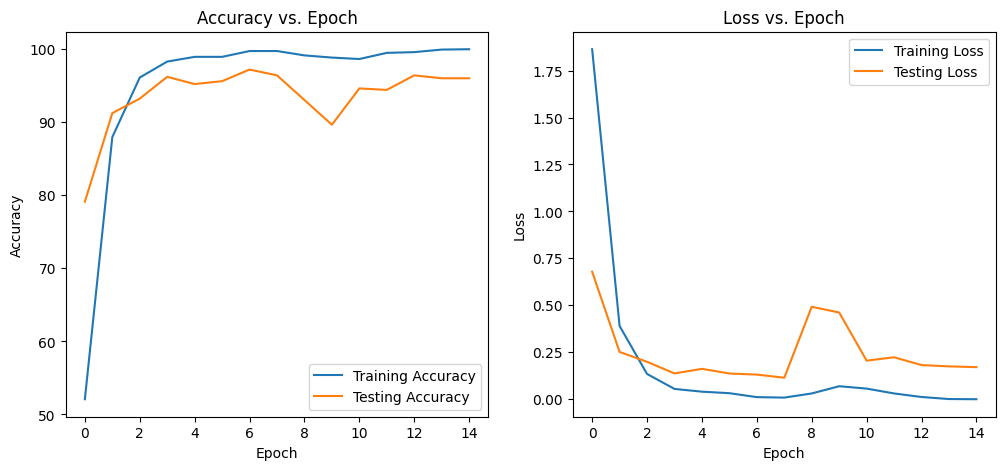

In [26]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epoch')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

plt.show()


In [27]:
# After prediction
_, predicted = torch.max(outputs.data, 1)
predicted_labels = [categories[p.item()] for p in predicted]

# For ground truth labels
true_labels = [categories[l.item()] for l in labels]


In [28]:
print(true_labels)

['c', 's', 'b', 'f', 'k', 'h', 'a', '0', 'a', 'x', 'a', '5', 'o', 't', '8', 'c', '7', 't', 'a', 'a', 'c', '6', 'x']
